### **Import Library**

In [99]:
# Library for Dataset Preparation, Processing, and Visualization
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sm

# Library for Machine Learning Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Pickle
import pickle

# TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from keras.models import load_model

# Pickle
from collections import defaultdict

### **Import Datasets**

In [100]:
df_train = pd.read_csv('dataset/train_preprocess.tsv', sep='\t', names=['text', 'label'])
df_train.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [101]:
df_train.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [102]:
df_test = pd.read_csv('dataset/data.csv', encoding='latin-1')
df_test = df_test[['Tweet']]
df_test = df_test.rename(columns = {'Tweet' :'text'})
df_test['text'].astype(str)
df_test.head()

,text
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


In [103]:
with open('dataset/combined_slang_words.json') as f:
    jsonstr = json.load(f)
df_slang = pd.DataFrame(list(jsonstr.items()),columns = ['slang','normal']) 

df_slang.head()

,slang,normal
0,@,di
1,abis,habis
2,ad,ada
3,adlh,adalah
4,afaik,as far as i know


In [104]:
df_stop = pd.read_csv('dataset/combined_stop_words.csv', encoding = 'latin-1', header = None)
df_stop.head()


,0
0,adalah
1,adapun
2,agaknya
3,akan
4,akhir


## **Cleansing**

In [105]:
print('-------------------------------')
print('Training dataset Null Values :')
print(df_train.isnull().sum())
print('-------------------------------')

print('Test dataset Null Values :')
print(df_test.isnull().sum())
print('-------------------------------')

-------------------------------
Training dataset Null Values :
text     0
label    0
dtype: int64
-------------------------------
Test dataset Null Values :
text    0
dtype: int64
-------------------------------


In [106]:
print('Training dataset duplicated Values :', df_train.duplicated().sum())
print()
print('Test dataset duplicated Values :', df_test.duplicated().sum())

Training dataset duplicated Values : 67

Test dataset duplicated Values : 146


In [107]:
df_train.drop_duplicates(inplace = True, ignore_index= True)
print('Jumlah Duplicated Values pada Training Dataset setelah dibersihkan :', df_train.duplicated().sum())

print()

df_test.drop_duplicates(inplace = True, ignore_index = True)
print('Jumlah Duplicated Values pada Test Dataset setelah dibersihkan :', df_test.duplicated().sum())


Jumlah Duplicated Values pada Training Dataset setelah dibersihkan : 0

Jumlah Duplicated Values pada Test Dataset setelah dibersihkan : 0


## **Function Cleansing**

In [108]:
def Cleansing(text):
    
    # Regrex
    text = text.lower() # membuat semua huruf menjadi lowercase
    text = text.strip() # menghapus spasi pada awal dan akhir kalimat
    text = re.sub('\n', ' ', text) # menghilangkan new line
    text = re.sub('x[a-z0-9]{,2}',' ', text) # menghilangkan rawstring emoji
    text = re.sub('user', ' ', text) # menghilangkan mention USER tertentu
    text = re.sub('url', ' ', text) # menghilangkan teks 'url' pada teks
    text = re.sub('http\S+', '', text) # menghilangkan url
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) # menghilangkan non-alpha numerik
    text = re.sub('( rt )|(rt )', ' ', text) # menghilangkan retweet
    text = re.sub('  +', ' ', text) # Menghilangkan spasi berlebih

    # Slangwords Normalization
    Slang_dict = dict(zip(df_slang['slang'], df_slang['normal']))  # Membuat dataframe slang menjadi dict
    holder = [] # variabel list untuk menyimpan kata slang yang sudah dinormalkan
    
    #pengulangan untuk mengubah word slang menjadi word yang sesuai pada dict
    for word in text.split(' '): 
        
        if word in Slang_dict.keys(): 
            word = Slang_dict[word] # mengubah kata slang menjadi kata yang sesuai pada dict
            holder.append(word) # simpan kata slang yang sudah normal ke variabel holder
        else :
            holder.append(word) 
            
    text = ' '.join(holder) # mengembalikan satu kalimat yang sudah digabungkan dari list huruf pada holder

    # Stopwords Removal
    holder = []
      
    for words in text.split(' '):
        if words in df_stop[0].values:
          holder.append(' ')
        else:
          holder.append(words)

    text = ' '.join(holder)
    text = re.sub(' +', ' ', text) # menghilangkan spasi berlebih
    text = text.strip() # menghilangkan whitespace pada awal dan akhir string

    return text
    

In [109]:
df_train.label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: label, dtype: int64

In [110]:
df_train['text_clean'] = df_train['text'].apply(Cleansing)
df_train.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung nyaman...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unbo g paket barang bagus menet...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning bela...


In [111]:
neg = df_train.loc[df_train['label'] == 'negative'].text_clean.tolist()
neu = df_train.loc[df_train['label'] == 'neutral'].text_clean.tolist()
pos = df_train.loc[df_train['label'] == 'positive'].text_clean.tolist()

neg_label = df_train.loc[df_train['label'] == 'negative'].label.tolist()
neu_label = df_train.loc[df_train['label'] == 'neutral'].label.tolist()
pos_label = df_train.loc[df_train['label'] == 'positive'].label.tolist()


In [112]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))
type(total_data)

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


list

### **Feature Extraction**

In [113]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('pickle/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('pickle/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [114]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('pickle/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


### **Prepare train & test datasets/Splitting Dataset**

In [115]:
file = open("pickle/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("pickle/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### **Training**

In [116]:
embed_dim = 256

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(SpatialDropout1D(0.76))
model.add(LSTM(32, dropout=0.77, recurrent_dropout=0.76))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=None)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 68, 256)           25600000  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 68, 256)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 32)                36992     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 25,637,091
Trainable params: 25,637,091
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
35/35 [==============================] - 16s 396ms/step - loss: 0.9769 - accuracy: 0.5508 - 

In [117]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 8ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       668
           1       0.84      0.71      0.77       231
           2       0.91      0.92      0.92      1288

    accuracy                           0.87      2187
   macro avg       0.85      0.82      0.83      2187
weighted avg       0.87      0.87      0.87      2187



In [118]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 256

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
    model.add(SpatialDropout1D(0.76))
    model.add(LSTM(32, dropout=0.77, recurrent_dropout=0.76))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=0, callbacks=None)

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 10ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       668
           1       0.82      0.71      0.76       231
           2       0.91      0.93      0.92      1288

    accuracy                           0.87      2187
   macro avg       0.85      0.82      0.83      2187
weighted avg       0.87      0.87      0.87      2187

69/69 [==============================] - 1s 8ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       668
           1       0.81      0.74      0.77       231
           2       0.91      0.92      0.92      1288

    accuracy                           0.87      2187
   macro avg       0.84      0.82      0.83      2187
weighted avg       0.87      0.87      0.87      2187

69/69 [==============================] - 1s 9ms/step
Training ke- 3
              precision    recall

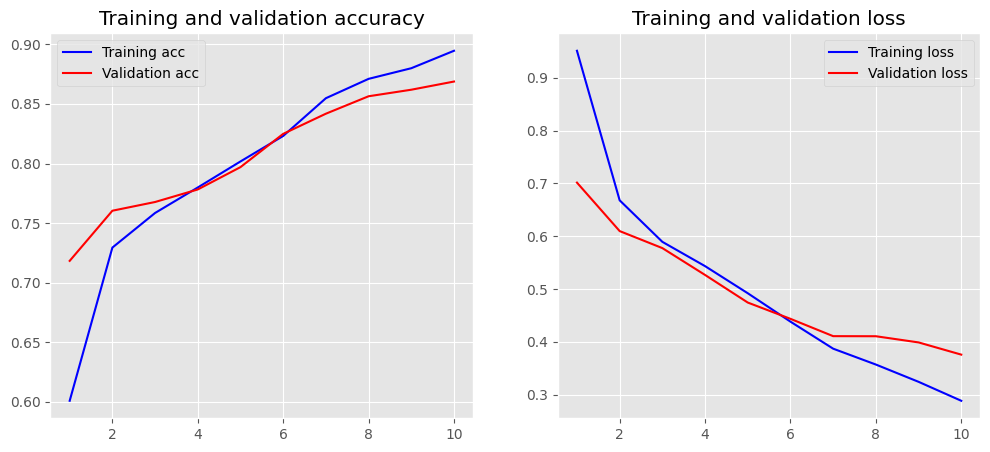

In [119]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [120]:
model.save('pickle/model.h5')
print("Model has created!")

Model has created!


### **Predict**

In [121]:
input_text = """
bukti persahabatan sejati putra presiden dg putra presiden semoga abadi seabadi usia voucher
"""

sentiment = ['negative', 'neutral', 'positive']

text = Cleansing(input_text)
text = [text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 180ms/step
Text:  bukti persahabatan sejati putra presiden dg putra presiden semoga abadi seabadi usia voucher
Sentiment:  neutral


In [122]:
input_text = """
cinta memang buta memilih salah
"""

sentiment = ['negative', 'neutral', 'positive']

text = Cleansing(input_text)
text = [text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 200ms/step
Text:  cinta memang buta memilih salah
Sentiment:  positive


In [123]:
prediction[0]

array([0.36730888, 0.01744652, 0.6152446 ], dtype=float32)

In [124]:
df_test['text'] = df_test.text.apply(Cleansing)
temp = df_test.text.tolist()

sentiment = ['negative', 'neutral', 'positive']

predicted = tokenizer.texts_to_sequences(temp)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)

holder = [ ]
for i in range(0,len(prediction)):
    polarity = np.argmax(prediction[i])
    holder.append(sentiment[polarity])


407/407 [==============================] - 5s 11ms/step


In [125]:
df_test['sentiment'] = holder
df_test

,text,sentiment
0,disaat cowok berusaha melacak perhatian lantas...,negative
1,terlambat edan sarap bergaul ciga jifla calis ...,negative
2,41 kadang berfikir percaya tuhan jatuh berkali...,negative
3,nku matamu sipit diliat,negative
4,kaum cebong kapir dongoknya awal dongok hahahah,negative
...,...,...
13018,bicara ndasmu mulut sekate2 anjyng,negative
13019,kasur enak kunyuk,positive
13020,hati hati bisu g nlagi bosan mengeluh,negative
13021,bom real mudah terdeteksi bom terkubur dahsyat...,positive


In [126]:
neg = df_test.loc[df_test['sentiment'] == 'negative'].text.tolist()
neu = df_test.loc[df_test['sentiment'] == 'neutral'].text.tolist()
pos = df_test.loc[df_test['sentiment'] == 'positive'].text.tolist()

In [127]:
print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))

Pos: 760, Neu: 1327, Neg: 10936


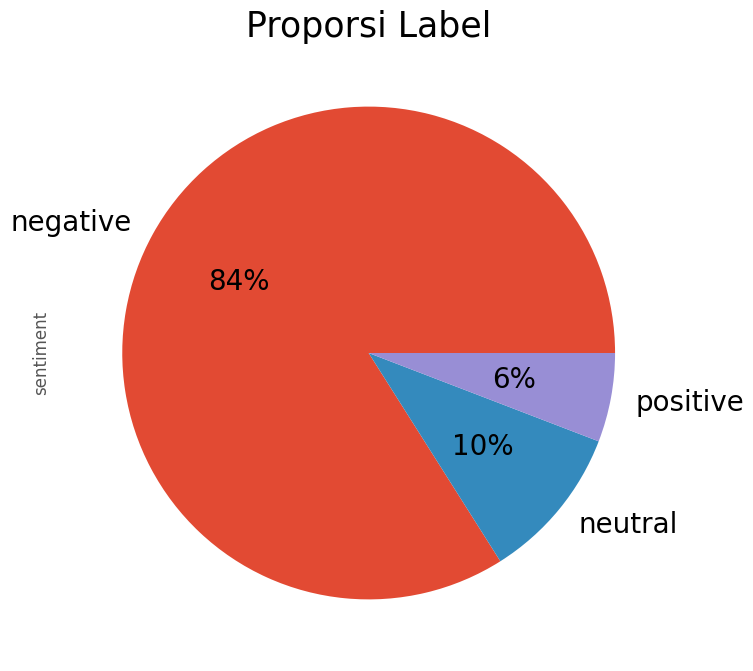

In [128]:
df_test['sentiment'].value_counts().plot(kind='pie', autopct='%1.00f%%', figsize=(8,8), fontsize = 20)
plt.title('Proporsi Label', fontsize=25)
plt.show()